# Groverのアルゴリズム（2020年 Week1b）

*下記の文章の解説部分は[Qiskit Textbool](https://qiskit.org/textbook/preface.html)の [グローバーのアルゴリズム](https://github.com/kifumi/qiskit-textbook/blob/ja/content/ch-algorithms/grover.ipynb) の抄訳ですが、"Qiskitでの実装"以降の部分はチャレンジ用に作成しています。*

このチュートリアルでは、量子アルゴリズムの一つであるGrover (グローバー) のアルゴリズムについて学びます。 そして、**当チュートリアルの最後には今週の問題がありますので、ぜひチャレンジしてみてください。** 

古典コンピューターを凌駕する量子コンピューターの数あるアドバンテージの１つに、データベース検索を高速に行えるというのを聞いたことがあるかも知れません。Groverのアルゴリズムはこの能力を実証します。Groverのアルゴリズムは、非構造化データの検索問題に対して二次のオーダーの高速化ができる（古典計算で$N$回の計算となる問題が、量子計算では約$\sqrt N$回になる）だけではなく、検索以外の用途でも利用することができます。つまり、その他様々のアルゴリズムの実行時間を二次のオーダーで改善する一般的なテクニック、もしくはサブルーチンとして利用することができます。これは振幅増幅テクニックと呼ばれています。

このページでは、検索問題の詳細を説明し、検索問題用のオラクル(Oracle)を回路で作成した後にGroverのアルゴリズムをQiskitを利用して実装します。

## 非構造化データの検索
$N$個の大きなアイテムリストがあるとします。その中で、一つだけアタリ$w$があるとします。

![](./resources/2019-w2-unstructured_search.png)

アタリの箱（マークのついたアイテム）を見つけるためには、古典計算では平均で $N/2$ 個の箱を探す必要があります。
最悪の場合は、$N$ 個探す必要があります。ところが、量子コンピューターでは Groverの振幅増幅のテクニックを使って、
おおよそ $\sqrt N$ ステップでマークされたアイテムを探し出すことができます。
二次の高速化は、大きなリスト内のマークされたアイテムを探すためには実際の所、大きな時間の節約になります。
さらに、このアルゴリズムはリスト自体の内部構造を利用しないので、一般化することができ、多くの古典の問題でも二次の速度向上をもたらしてくれます。

## オラクル
量子コンピューターにこのようなリストをどのように提供すればいいでしょうか？このようなリストをエンコードするためによく用いられる手法としては、マークのついていない$x$には$f(x)=0$を返し、アタリ$w$に対しては$f(w)=1$を返すような関数$f$を定義する手法が挙げられます。この問題に対して量子コンピューターを使用するには、この関数に対して、重ね合わせ状態にあるアイテムを提供する必要があります。つまり、この関数をオラクルと呼ばれるユニタリー行列としてエンコードする必要があります。そのために、まず初めにアイテムをバイナリ表現にします。すなわち、$x,w \in \{0,1\}^n$で$N=2^n$です。このようにすると量子コンピューター上の量子ビットとして表現することができます。その後、オラクル行列$U_w$を任意の標準基底$|x\rangle$に対して$U_w |x\rangle =(-1)^{f(x)}|x\rangle$となるように定義します。

$x$がマークされていないアイテムの場合、オラクルは状態に対して何もしません。ところが、状態$|w\rangle$に対してオラクルを適用すると、$U_w |w\rangle = -|w\rangle$にマッピングします。幾何学的には、このユニタリー行列は$N=2^n$次元のベクトル空間において、マークされたアイテムを原点に対して反転する操作に対応しています。

![](./resources/2019-w2-oracle.png)

## 振幅増幅（Amplitude amplification）
では、アルゴリズムはどのように動作するのでしょう？リストを調べる前は、私たちはマークされたアイテムがどこにあるのか知りません。従って、下記の式で表される均一な重ね合わせ状態です。
$$ |s\rangle = \frac{1}{\sqrt N}\sum_{x=0}^{N-1} |x\rangle $$

もしこの時点で標準基底 $|x\rangle $でこの重ね合わせ状態を測定した場合、$\frac{1}{N} = \frac{1}{2^{n}} $ の確率で、標準基底のうちの一つに収束します。予想通り、正しい$|w\rangle$を当てる確率は$\frac{1}{2^{n}}$ です。従って、正しいアイテムを推測するには、平均$N=2^{n}$回トライする必要があります。


そこで振幅増幅と呼ばれる処理を加えましょう。この処理により、量子コンピューターが正しいアイテムを見つける確率を大幅に高めることが出来ます。この処理では、マークされたアイテムの振幅を増幅し、その他のアイテムの振幅を小さくします。この結果、最終状態を測定すると、正しいアイテムをほぼ確実に取り出すことができるようになります。

このアルゴリズムには２つの反転という面白い幾何学的解釈があり、２次元平面での回転として表せます。私たちが考慮すべきは、アタリ$|w\rangle$ と均一な重ね合わせ状態$|s\rangle$ の２つの特別な状態のみです。この２つのベクトルは、ベクトル空間 $\mathbb C^{N}$ において、２次元の平面を張ります。$|w\rangle$ 状態は、$N^{-1/2}$ の振幅で重ね合わせ状態に入っているため、これら２つのベクトルは完全に直交しているわけではありません。

しかし、$|s\rangle$ から $|w\rangle$ を削除し、正規化し直す事で$|w\rangle$ に直交する追加の状態 $|s'\rangle$ を導入することができます


### Step 0:
振幅増幅は均一な重ね合わせ状態 $|s\rangle$ から開始します。均一な重ね合わせ状態は、$|s\rangle = H^{\otimes n}|0\rangle^{n}$ により簡単に作成できます。$t=0$ の時、初期状態は $|\psi_{0}\rangle = |s\rangle$ です。

![](./resources/2019-w2-step0.png)

左の図は、$|w\rangle, |s'\rangle$ によって張られる、２次元平面に対応しています。右の図は、$N=2^n$ の場合の、状態 $|\psi_{t}\rangle$ の振幅を表す棒グラフです。振幅の平均値は破線で示されています。

### Step 1:
反転のオラクル $U_{w}$ を状態に適用します $U_{w}|\psi_{t}\rangle = |\psi_{t'}\rangle$                                                                                                                            

![](./resources/2019-w2-step1.png)

幾何学的には、状態 $|\psi_{t}\rangle$ を $|s'\rangle$ に対して反転させることに対応しています。この変換が意味することは、$|w\rangle$ 状態の振幅が負の値になるということで、結果として平均振幅が低くなることを意味しています。(右側のグラフで破線が下がっていることに着目してください）。

### Step 2:
次に、$|s\rangle$ に対する追加の反転 $U_{s}$ を適用します：$U_{s} = 2|s\rangle \langle s| - 1 $ 。この変換の結果、状態は $U_{s}|\psi_{t'}\rangle$ となり、変換 $|\psi_{t+1}\rangle = U_{s}U_{w}|\psi_{t}\rangle$ が完了します。（右側のグラフで$|w\rangle$に対応する振幅が増幅されていることに着目してください）。

![](./resources/2019-w2-step2.png)

２つの反転は常に回転と対応しています。$ U_{s}U_{w}$ による変換は、初期状態 $|s\rangle$ をアタリ$|w\rangle$ に近づけるような回転となります（Step 2の左側の図を参照)。$U_{s}$ による反転の効果は、振幅の棒グラフにおいて、平均振幅での反転と解釈できます。最初の反転で平均振幅の値が低くなったので、この変換は、負の振幅をもった $|w\rangle$ をオリジナルの値から大雑把にいって約３倍程度増幅し、他の振幅は小さくします。その後、**Step １** に戻ってこれを繰り返します。アタリ $w$に近くなるまで、この処理を何回か繰り返します。

$t$ 回繰り返した後、状態は $|\psi_{t}\rangle = (U_{s}U_{w})^{t}|\psi_{0}\rangle $ に変換されます。

回転を何回適用する必要があるでしょうか？ おおよそ $\sqrt N$ 回転で十分なことが分かっています。これは、状態 $|\psi_{t}\rangle$ の振幅を調べることで明確になります。$|w\rangle$ の振幅が適用回数と共に線型的（$ \sim tN^{1/2}$）に増えていくことが見てとれます。確率ではなく振幅を扱っているので、ベクトル空間の値には平方根として入ります。そのため、この処理で増幅されるのは、ただの確率ではなく振幅です。

もし解が複数、$M$個ある場合、おおよそ$\sqrt{(N/M)}$ 回転で十分なことが分かっています。

![](./resources/2019-w2-grover_algorithm.png)

### Qiskitでの実装: 2量子ビットのGroverのアルゴリズム
では、GroverのアルゴリズムをQiskitで実装してみましょう。今回は、2量子ビットを使って、$|11\rangle$を見つけるGroverのアルゴリズムを実装します。

最初に環境を準備します。

In [7]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

上のStep1で実施したように求めたい解（今回の場合、$|11\rangle$）の符号を反転するオラクルを作成します。

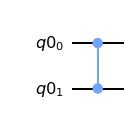

In [8]:
def phase_oracle(circuit, register):
    circuit.cz(register[0], register[1])

qr = QuantumRegister(2)
oracleCircuit = QuantumCircuit(qr)
phase_oracle(oracleCircuit, qr)
oracleCircuit.draw(output="mpl")

次にStep 2で実施した平均についての反転(inversion about averate)をする回路を作成します。この回路はDiffusion回路と呼ばれることもあります。

In [9]:
def inversion_about_average(circuit, register):
    """Apply inversion about the average step of Grover's algorithm."""
    circuit.h(register)
    circuit.x(register)
    circuit.h(register[1])
    circuit.cx(register[0], register[1])
    circuit.h(register[1])
    circuit.x(register)
    circuit.h(register)

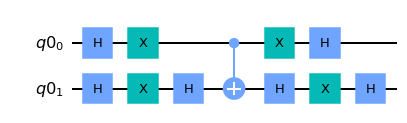

In [10]:
qAverage = QuantumCircuit(qr)
inversion_about_average(qAverage, qr)
qAverage.draw(output='mpl')

回路の初めで均一な重ね合わせ状態を準備し、今まで作成した部品を合わせ、最後に測定を行います。四つの可能性のうち解は一つなので、繰り返し回数は一回であることに注意してください。

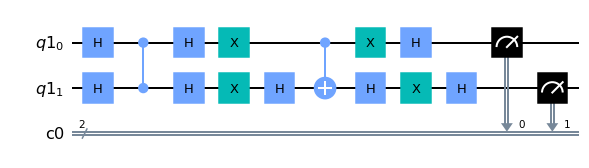

In [11]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

groverCircuit = QuantumCircuit(qr,cr)
groverCircuit.h(qr)

phase_oracle(groverCircuit, qr)
inversion_about_average(groverCircuit, qr)

groverCircuit.measure(qr,cr)
groverCircuit.draw(output="mpl")

### シミュレーターでの実験
上記の回路をシミュレーターで実行してみます。

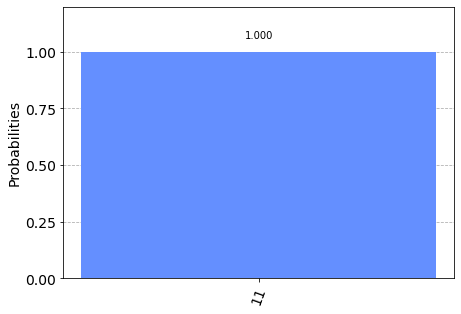

In [12]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

実行結果から分かるようにGroverのアルゴリズムは解を発見しています。

### 実デバイスでの実験
以下に示すように、実デバイスで実験を行うこともできます。

In [13]:
# Load our saved IBMQ accounts and get the least busy backend device

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend_lb = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
print("Least busy backend: ", backend_lb)

//anaconda3/envs/qiskit023/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Least busy backend:  ibmq_16_melbourne


In [14]:
# run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

backend = backend_lb
shots = 1024
job_exp = execute(groverCircuit, backend=backend, shots=shots)

job_monitor(job_exp, interval = 2)

Job Status: job has successfully run


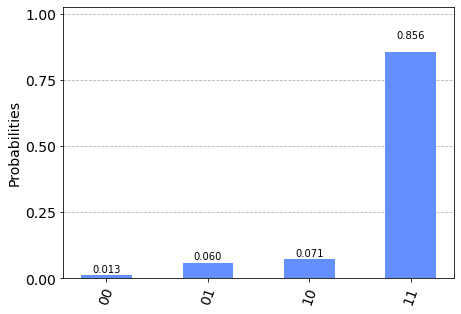

In [15]:
# get the results from the computation
results = job_exp.result()
answer = results.get_counts(groverCircuit)
plot_histogram(answer)

### Qiskitでの実装: 補助量子ビットを用いた2量子ビットのGroverのアルゴリズム
同じ$|11\rangle$を見つける2量子ビットのGroverのアルゴリズムですが、今回は求めたい解の符号を反転する際に補助量子ビットを用いた回路を実装しましょう。補助量子ビットを用いることで、量子ビットの数が増えた際や問題が難しい際の複雑なオラクルを実装しやすくなります。

最初に環境を準備します。

In [16]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

求めたい解（今回の場合、$|11\rangle$）の符号を反転するオラクルを作成します。但し、今回は補助量子ビットを用いて$|11\rangle$の場合に符号が反転するようにします。この際、正しく符号を反転させるためには事前に補助ビットを$|1\rangle$にする必要があることに注意してください。

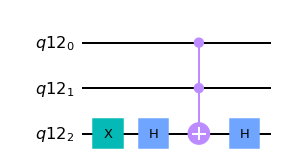

In [17]:
def phase_oracle(circuit, register,oracle_register):
    circuit.h(oracle_register)
    circuit.ccx(register[0], register[1],oracle_register)
    circuit.h(oracle_register)
    
qr = QuantumRegister(3)
oracleCircuit = QuantumCircuit(qr)
oracleCircuit.x(qr[2])
phase_oracle(oracleCircuit, qr,qr[2])
oracleCircuit.draw(output="mpl")

次に、Diffusion回路を準備します。Diffusion回路は補助ビットには作用しないようにしてください。

In [18]:
def inversion_about_average(circuit, register):
    """Apply inversion about the average step of Grover's algorithm."""
    circuit.h(register)
    circuit.x(register)
    circuit.h(register[1])
    circuit.cx(register[0], register[1])
    circuit.h(register[1])
    circuit.x(register)
    circuit.h(register)

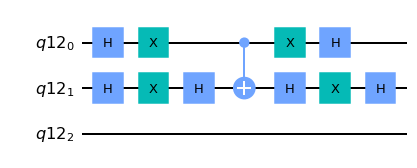

In [19]:
qAverage = QuantumCircuit(qr)
inversion_about_average(qAverage, qr[0:2])
qAverage.draw(output='mpl')

補助ビットなしで作成した回路と同じように、回路の最初で均一な重ね合わせ状態を作成し（この際、補助ビットにHゲートをかけないように注意してください）、変換を適用し、最後に測定をします。

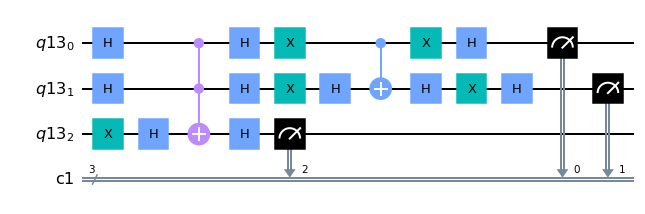

In [20]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

groverCircuit = QuantumCircuit(qr,cr)
groverCircuit.h(qr[0:2])
groverCircuit.x(qr[2])

phase_oracle(groverCircuit, qr,qr[2])
inversion_about_average(groverCircuit, qr[0:2])

groverCircuit.measure(qr,cr)
groverCircuit.draw(output="mpl")

### シミュレーターでの実験
上記の回路をシミュレーターで実行してみます。

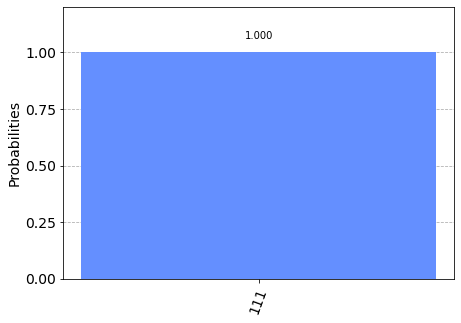

In [21]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

補助ビットなしで作成した回路と同じように$|11\rangle$の状態の確率が増幅されていることが確認できます。最上位ビットの1は補助量子ビットのものなので無視して問題ありません。

## TIPS: 繰り返しの回数
先ほど、グローバーのアルゴリズムは、解が完全に増幅されるまで約$\sqrt{N}$回繰り返しますと述べましたが、最も解が大きくなる繰り返し回数について考えてみましょう。

例えば、$N = 2^4$のデータベースにおいてグローバーのアルゴリズムを実行させるとき、その回の測定確率は以下のように繰り返しの回数によって変化します。

In [22]:
backend = BasicAer.get_backend('qasm_simulator')
prob_of_ans = []

for x in range(12):
    database = QuantumRegister(4)
    oracle = QuantumRegister(1)
    auxiliary = QuantumRegister(2) 
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(database, oracle, auxiliary, cr)
    qc.h(database[:])
    qc.x(oracle[0])
    qc.h(oracle[0])


    for j in range(x):
    # oracle_4q
        # search 7: 0111 
        qc.x(database[0])
        qc.mct(database[:], oracle[0], auxiliary[:], mode='basic') 
        qc.x(database[0])

    # diffusion_4q
        qc.h(database[:])
        qc.x(database[:])
        qc.h(database[3])
        qc.mct(database[0:3], database[3], auxiliary[:], mode='basic')
        qc.h(database[3])
        qc.x(database[:])
        qc.h(database[:])


    qc.h(oracle[0])
    qc.x(oracle[0])
    qc.measure(database,cr)
    # Change the endian 
    qc = qc.reverse_bits() 
    
    job = execute(qc, backend=backend, shots=1000, seed_simulator=12345, backend_options={"fusion_enable":True})
    result = job.result()
    count = result.get_counts()
    answer = count['0111']
    prob_of_ans.append(answer)

Text(0, 0.5, '# of times the solution was obtained')

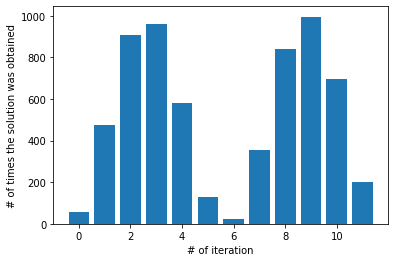

In [23]:
import numpy as np
import matplotlib.pyplot as plt
iteration = [i for i in range(12)]
correct = prob_of_ans
plt.bar(iteration, correct)
plt.xlabel('# of iteration')
plt.ylabel('# of times the solution was obtained')

## ラーニング演習 I-B

````{admonition} 最大振幅を得る繰り返し回数
$N = 2 ^ 7$のデータベースにおいてグローバーのアルゴリズムを実行するときに最大振幅を得る繰り返しの回数を答えよ。  
上の例で示したように、繰り返し回数を変えて、振幅を調べよ。解答は整数である必要があります。

```{hint}
答えは、15回以下です。
```

```

````